Group 26 group project 

Group 26 Group Members: Henil Agrawal, Xiaotao Feng, Nadav Segev, Carter Yam 

Title: Predictive Analysis of Diabetes Risk Among Female Pima Indians Over 21 Using KNN Classification

Introduction:

Diabetes, a prevalent chronic disease, profoundly impacts millions of individuals and their families annually. Researchers have been drawn to its complexities, particularly its rising prevalence among the Pima Indians in the mid-20th century. There are many factors causing diabetes. Notably, a 2019 study revealed that women with 1 to 3 pregnancies face a 1.7 times higher risk of developing diabetes, based on an analysis of 768 Pima Indian females over 21 (Bashir et al., 2019). 
In our project, we aim to solve the question: how can we predict who among the female Pima Indian population over the age of 21 have diabetes by applying KNN classification method? 
We utilize a dataset with eight quantitative predictors, including glucose concentration, blood pressure levels and a categorical variable indicating diabetes status.

In [12]:
install.packages("cowplot")
install.packages("janitor")
install.packages("gridExtra")
install.packages("kknn")
library(tidyverse)
library(tidymodels)
library(cowplot)
library(repr)
library(stringr)
library(janitor)
library(gridExtra)
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [13]:
#Reading the dataset "diabetes"
diabetes <- read_csv("diabetes.csv", col_names = TRUE)
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [14]:
#Cleaning the dataset
diabetes <- diabetes |> clean_names()
head(diabetes)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [15]:
#Wrangling the data
diabetes <- diabetes |> mutate(outcome = as_factor(outcome), 
                               age = as.integer(age), 
                               pregnancies = as.integer(pregnancies)) |> 
            mutate(outcome = fct_recode(outcome, "Confirmed" = "1", "Healthy" = "0")) |>
            na.omit()
head(diabetes)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
6,148,72,35,0,33.6,0.627,50,Confirmed
1,85,66,29,0,26.6,0.351,31,Healthy
8,183,64,0,0,23.3,0.672,32,Confirmed
1,89,66,23,94,28.1,0.167,21,Healthy
0,137,40,35,168,43.1,2.288,33,Confirmed
5,116,74,0,0,25.6,0.201,30,Healthy


In [16]:
#Splitting the data into train and test set
set.seed(2000)
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = "outcome")
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)

In [17]:
#Counting the Number of Observations for Each Identified Class "Healthy" and "Confirmed"
Observations_by_class <- diabetes_training |> 
                            group_by(outcome) |> 
                            summarize(number_of_observations = n())
Observations_by_class

outcome,number_of_observations
<fct>,<int>
Healthy,375
Confirmed,201


In [18]:
#To find the average value of each Predictor Variables we chose to use for each class
Mean_values <- diabetes_training |> 
                select(-insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(pregnancies:age, mean)) 
Mean_values

#To find the maximum value of each Predictor Variables we chose to use for each class
Max_values <- diabetes_training |> 
                select(-insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(pregnancies:age, max)) 
Max_values

#To find the minimum value of each Predictor Variables we chose to use for each class
Min_values <- diabetes_training |> 
                select(-insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(pregnancies:age, min)) 
Min_values

outcome,pregnancies,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy,3.248000,109.7307,68.58400,20.04800,30.15040,31.42667
Confirmed,4.820896,140.2985,71.27861,22.33831,35.31144,36.54726


outcome,pregnancies,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,13,194,122,54,57.3,81
Confirmed,15,199,114,99,67.1,70


outcome,pregnancies,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,0,0,0,0,0,21
Confirmed,0,0,0,0,0,21


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


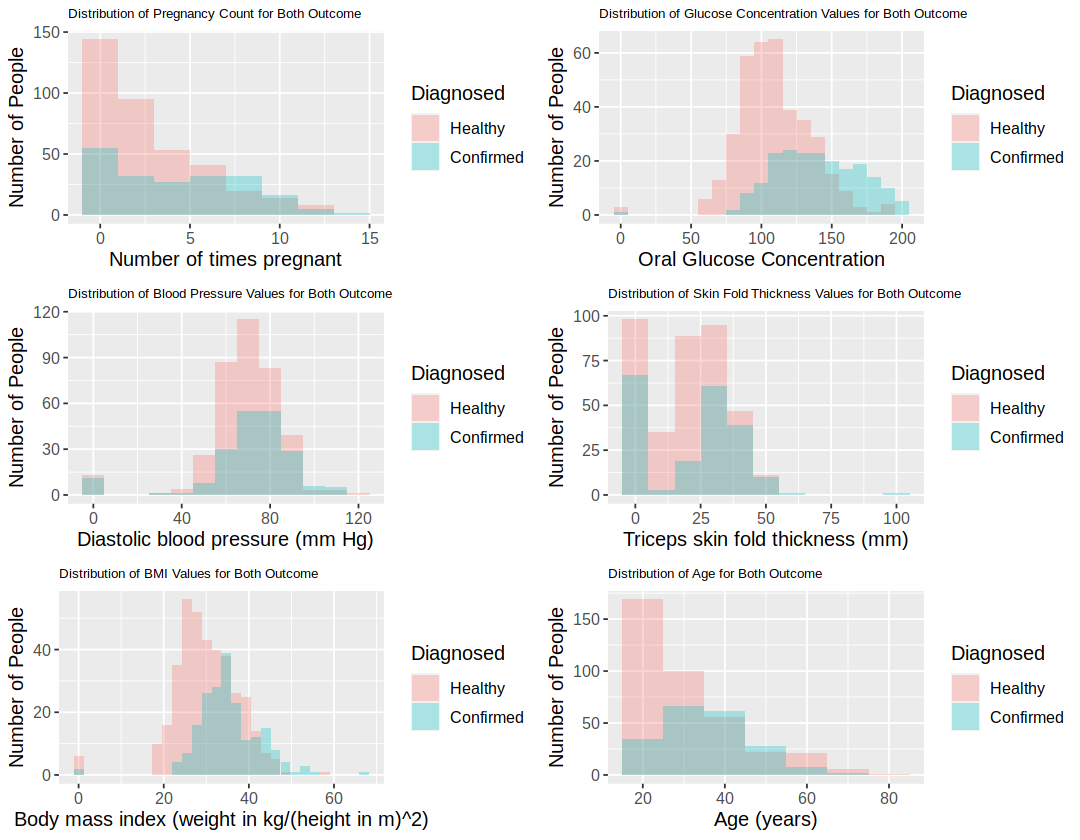

In [19]:
options(repr.plot.width = 9, repr.plot.height = 7)

#Distribution of standardized data for each variable
pregnancy_distribution <- ggplot(diabetes_training, aes(x = pregnancies, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 2) +
                                        labs(x = "Number of times pregnant", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Distribution of Pregnancy Count for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

glucose_concentration_distribution <- ggplot(diabetes_training, aes(x = glucose, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Oral Glucose Concentration", y = "Number of People", fill = "Diagnosed") + 
                                        ggtitle("Distribution of Glucose Concentration Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

blood_pressure_distribution <- ggplot(diabetes_training, aes(x = blood_pressure, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Diastolic blood pressure (mm Hg)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Distribution of Blood Pressure Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

skin_thickness_distribution <- ggplot(diabetes_training, aes(x = skin_thickness, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Triceps skin fold thickness (mm)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Distribution of Skin Fold Thickness Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

bmi_distribution <- ggplot(diabetes_training, aes(x = bmi, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity") +
                                        labs(x = "Body mass index (weight in kg/(height in m)^2)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Distribution of BMI Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

age_distribution <- ggplot(diabetes_training, aes(x = age, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Age (years)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Distribution of Age for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

grid.arrange(pregnancy_distribution, glucose_concentration_distribution, blood_pressure_distribution, skin_thickness_distribution, bmi_distribution, age_distribution, nrow = 3)

Methods:

We will be developing multiple KNN-classification models using various combinations of predictor variables. This will enable us to compare the models and their prediction accuracies utilizing the cross-validation method, allowing us to identify the most effective predictor variables for diabetes in Pima Indian women. 
We will consider 6 of the 8 variables as our predictor variables: glucose levels, blood pressure, skin fold thickness, BMI, age, and number of pregnancies as these first four variables’ values are less skewed and exhibit more balanced distributions without significant outliers. We also use age and number of times pregnant as we hypothesize that this variable might significantly impact the presence of diabetes although being skewed. The response variable, outcome, indicates diabetes presence in Pima Indians. We will visualise the results using a scatterplot, with data points color-coded by outcome. 
We excluded 'DiabetesPedigreeFunction' due to insufficient description in the dataset, and lack of details on how the pedigree levels are defined. We omitted 'Insulin' because its reverse-causal relationship: individuals inject insulin due to having diabetes, making it irrelevant for predicting diabetes in new observations.


pregnancies,glucose,blood_pressure,skin_thickness,bmi,age,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.6462190,0.8814192,0.1296651,0.8900175,0.2086613,1.41701936,Confirmed
1.2328575,1.9990626,-0.2893369,-1.3110071,-1.0949885,-0.10244043,Confirmed
-1.1136966,0.5301599,-1.5463432,0.8900175,1.4110568,-0.01802600,Confirmed
-0.2337388,-1.3538675,-1.0225906,0.7013583,-0.1204153,-0.60892703,Confirmed
1.2328575,0.1469679,1.3866714,-1.3110071,-4.0440216,1.75467709,Confirmed
1.8194960,1.5200726,0.2344157,-1.3110071,0.7655603,0.06638843,Confirmed


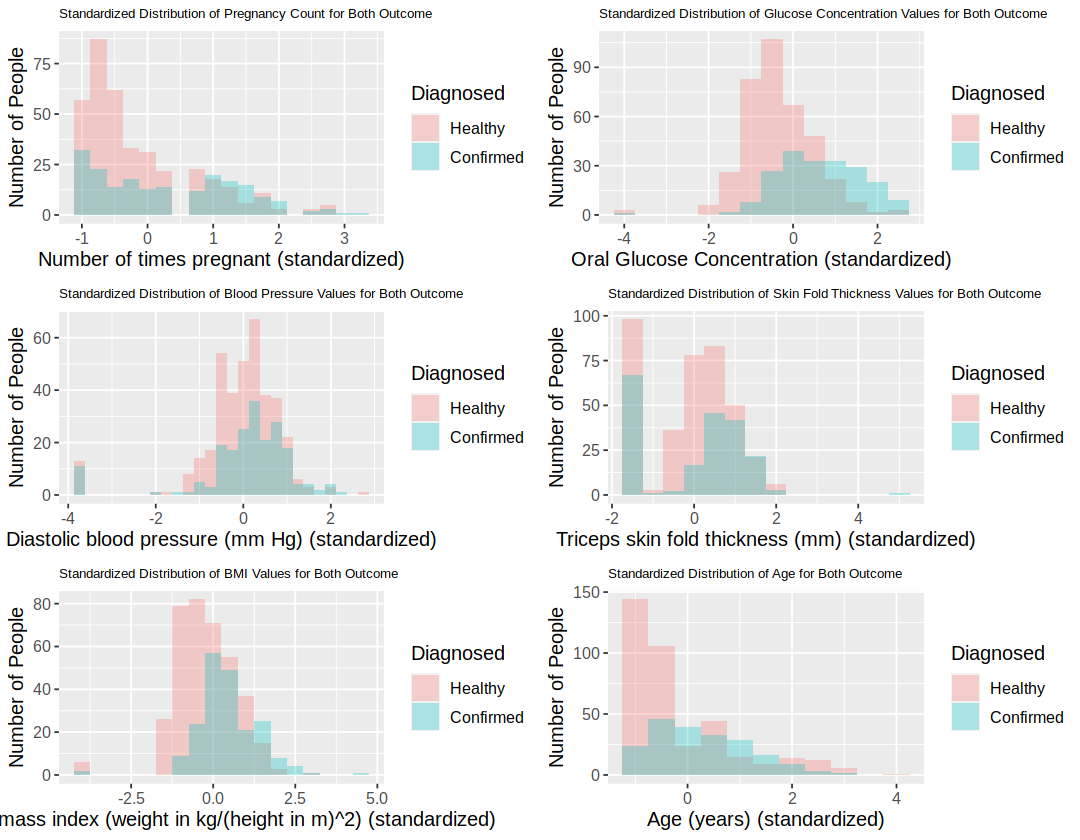

In [20]:
# Creating a recipe and standardizing the data 
# removing unwanted variables (insulin and diabetes_pedigree_function) as explained under "Methods"
diabetes_recipe <- recipe(outcome ~. , diabetes_training) |>
                    step_rm(insulin, diabetes_pedigree_function) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())


preprocessed_diabetes <- diabetes_recipe |> 
                        prep() |> 
                        bake(diabetes_training)

head(preprocessed_diabetes)

#Distribution of standardized data for each variable
pregnancy_distribution <- ggplot(preprocessed_diabetes, aes(x = pregnancies, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.25) +
                                        labs(x = "Number of times pregnant (standardized)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Standardized Distribution of Pregnancy Count for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

glucose_concentration_distribution <- ggplot(preprocessed_diabetes, aes(x = glucose, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.5) +
                                        labs(x = "Oral Glucose Concentration (standardized)", y = "Number of People", fill = "Diagnosed") + 
                                        ggtitle("Standardized Distribution of Glucose Concentration Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

blood_pressure_distribution <- ggplot(preprocessed_diabetes, aes(x = blood_pressure, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.25) +
                                        labs(x = "Diastolic blood pressure (mm Hg) (standardized)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Standardized Distribution of Blood Pressure Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

skin_thickness_distribution <- ggplot(preprocessed_diabetes, aes(x = skin_thickness, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.5) +
                                        labs(x = "Triceps skin fold thickness (mm) (standardized)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Standardized Distribution of Skin Fold Thickness Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

bmi_distribution <- ggplot(preprocessed_diabetes, aes(x = bmi, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.5) +
                                        labs(x = "Body mass index (weight in kg/(height in m)^2) (standardized)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Standardized Distribution of BMI Values for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

age_distribution <- ggplot(preprocessed_diabetes, aes(x = age, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 0.5) +
                                        labs(x = "Age (years) (standardized)", y = "Number of People", fill = "Diagnosed") +
                                        ggtitle("Standardized Distribution of Age for Both Outcome") +
                                        theme(text = element_text(size = 12), plot.title = element_text(size = 8))

grid.arrange(pregnancy_distribution, glucose_concentration_distribution, blood_pressure_distribution, skin_thickness_distribution, bmi_distribution, age_distribution, nrow = 3)

CROSS-VALIDATION

In [49]:
#Set the seed
#Performing cross-validation using multiple combinations of predictor variables while tuning the models with different values of K

set.seed(1234)

diabetes_vfold <- diabetes_training |> vfold_cv(v = 5, strata = outcome)
k_vals <- tibble(neighbors = seq(from = 1, to = 7, by = 1))

diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

#First: Using All Predictor Variables Selected

diabetes_recipe_all <- recipe(outcome ~. , diabetes_training) |>
                    step_rm(insulin, diabetes_pedigree_function) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_all <- workflow() |>
                        add_recipe(diabetes_recipe_all) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_all <- diabetes_results_all |> slice_max(mean, n = 1)
                        
best_result_all


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7482159,5,0.01472945,Preprocessor1_Model7


In [45]:
#Second: Using "glucose", "blood_pressure", "skin_thickness" as Predictor Variables Selected

diabetes_recipe_gl_bp_st <- recipe(outcome ~ glucose + blood_pressure + skin_thickness , diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_gl_bp_st <- workflow() |>
                        add_recipe(diabetes_recipe_gl_bp_st) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_gl_bp_st <- diabetes_results_gl_bp_st |> slice_max(mean, n = 1)
                        
best_result_gl_bp_st

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7273763,5,0.01148485,Preprocessor1_Model7


In [46]:
#Third: Using "blood_pressure", "skin_thickness" as Predictor Variables Selected

diabetes_recipe_bp_st <- recipe(outcome ~ blood_pressure + skin_thickness , diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_bp_st <- workflow() |>
                        add_recipe(diabetes_recipe_bp_st) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_bp_st <- diabetes_results_bp_st |> slice_max(mean, n = 1)
                        
best_result_bp_st

#Fourth: Using "glucose", "skin_thickness" as Predictor Variables Selected

diabetes_recipe_gl_st <- recipe(outcome ~ glucose + skin_thickness, diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_gl_st <- workflow() |>
                        add_recipe(diabetes_recipe_gl_st) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_gl_st <- diabetes_results_gl_st |> slice_max(mean, n = 1)
                        
best_result_gl_st

#Fifth: Using "glucose", "blood_pressure" as Predictor Variables Selected

diabetes_recipe_gl_bp <- recipe(outcome ~ glucose + blood_pressure, diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_gl_bp <- workflow() |>
                        add_recipe(diabetes_recipe_gl_bp) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_gl_bp <- diabetes_results_gl_bp |> slice_max(mean, n = 1)
                        
best_result_gl_bp

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.5885607,5,0.01480702,Preprocessor1_Model7


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.6995952,5,0.01417968,Preprocessor1_Model5


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.7187256,5,0.007778943,Preprocessor1_Model5


- From the first set of analysis above utilizing different combinations of predictor variables, we can see that glucose is the most important variable required to predict diabetes in Pima Indian females.  

In [54]:
#Sixth: Using "pregnancies", "bmi", "age" as Predictor Variables Selected

diabetes_recipe_preg_bmi_age <- recipe(outcome ~ pregnancies + bmi + age , diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_preg_bmi_age <- workflow() |>
                        add_recipe(diabetes_recipe_preg_bmi_age) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_preg_bmi_age <- diabetes_results_preg_bmi_age |> slice_max(mean, n = 1)
                        
best_result_preg_bmi_age

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.6909595,5,0.01551082,Preprocessor1_Model3
4,accuracy,binary,0.6909595,5,0.01551082,Preprocessor1_Model4


In [ ]:
#Seventh: Using "bmi", "age" as Predictor Variables Selected

diabetes_recipe_bmi_age <- recipe(outcome ~ bmi + age , diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_bmi_age <- workflow() |>
                        add_recipe(diabetes_recipe_bmi_age) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_bmi_age <- diabetes_results_bmi_age |> slice_max(mean, n = 1)
                        
best_result_bmi_age

#Eight: Using "pregnancies", "age" as Predictor Variables Selected

diabetes_recipe_preg_age <- recipe(outcome ~ pregnancies + age , diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_preg_age <- workflow() |>
                        add_recipe(diabetes_recipe_preg_age) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_preg_age <- diabetes_results_preg_age |> slice_max(mean, n = 1)
                        
best_result_preg_age

#Ninth: Using "pregnancies", "bmi" as Predictor Variables Selected

diabetes_recipe_preg_bmi <- recipe(outcome ~ pregnancies + bmi, diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

diabetes_results_preg_bmi <- workflow() |>
                        add_recipe(diabetes_recipe_preg_bmi) |>
                        add_model(diabetes_spec) |>
                        tune_grid(resamples = diabetes_vfold, grid = k_vals)|>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

best_result_preg_bmi <- diabetes_results_preg_bmi |> slice_max(mean, n = 1)
                        
best_result_preg_bmi

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7117541,5,0.01461655,Preprocessor1_Model7


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.6266717,5,0.02387587,Preprocessor1_Model5


- From the second set of analysis above utilizing different combinations of predictor variables, we can see that bmi and age is the most important variable required to predict diabetes in Pima Indian females.  

Expected Outcomes and Significance:

Our classification models aim to predict diabetes in the Pima Indian community and contribute to the knowledge surrounding diabetes afflicting them, thereby facilitating the development of targeted interventions and personalized healthcare strategies for this at-risk population. From the analyzed dataset, we predict that glucose levels and age would be the most useful predictors as we observe a significant difference in the distribution of the standardized data for these 2 variables between the 2 classes.

We’ll be able to effectively analyze the significance of relevant health-related predictors for diagnosing Pima women through comparison of different predictor combinations. Serving as an inexpensive preliminary diagnosis method, our classification model aids in improving healthcare technologies and addressing environmental factors contributing to diabetes. Additionally, we can explore hereditary and environmental influences on diabetes, helping identify risk factors for future generations. By deducing critical factors from our data, we can guide research to prevent disease and reduce healthcare burdens.

Further discussion may help us explore broader implications and extend the scope of our investigation. What are the underlying mechanisms of diabetes during pregnancy that impact future generations? To what extent do external factors, such as lifestyle choices and dietary patterns, contribute to diabetes in the community, and how can these findings be applied to public health initiatives aimed at reducing the overall burden of diabetes within indigenous communities?


References

Bashir, I. A, Mariod, A. A., Banu, R. & Elyas, T. B. (2019). Significance of Health Related Predictors of Diabetes in Pima Indians Women. Current Research in Nutrition and Food Science Journal, 7(2). http://dx.doi.org/10.12944/CRNFSJ.7.2.05
